# Principal Component Analysis (PCA) on NFWBS_PUF_2016_data

The goal of Principal Component Analysis (PCA) is to reduce the **number of dimensions** of a d-dimensional dataset by projecting it onto a k-dimensional subspace (with k < d) in order to increase the **computational efficiency** while retaining most of the information.

The k dimensions that we keep (eigenvectors) are called "**principal components**".

The PCA approach requires to:

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from a Singular Vector Decomposition (SVD).
* Choose the number k of principal components to keep.
* Construct a projection matrix with the selected k eigenvectors.
* Project original dataset to a k-dimensional feature subspace.

Choosing the number k can be done systematically by selecting the components that best describe the variance in our data. The amount of information (variance) contained by each eigenvector can be measured by the **explained variance**.

This notebook will display the explained variance for your dataset and help you choose the right amount of eigenvectors ("principal components").

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [Computation of the PCA](#pca)
* [Display of the explained variance](#explained-variance)
* [Retaining of the most significant components](#final-pca)
* [Visualizing the vectors in the original space](#original-space)
* [Applying the projection](#apply)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [1]:
%pylab inline
import dataiku                               # Access to Dataiku datasets
import pandas as pd, numpy as np             # Data manipulation 
from sklearn.decomposition import PCA        # The main algorithm
from matplotlib import pyplot as plt         # Graphing
import seaborn as sns                        # Graphing
from collections import defaultdict, Counter # Utils
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Populating the interactive namespace from numpy and matplotlib


The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing PCA requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

Also, by default, date features are not kept. Modify the following cell to change that.

In [2]:
dataset_limit = 10000
keep_dates = False

Load a DSS dataset as a Pandas dataframe

In [3]:
# Take a handle on the dataset
mydataset = dataiku.Dataset("NFWBS_PUF_2016_data")

# Load the first lines.
# You can also load random samples, limit yourself to some columns, or only load
# data matching some filters.
#
# Please refer to the Dataiku Python API documentation for more information
df = mydataset.get_dataframe(limit = dataset_limit)

df_orig = df.copy()

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print "Loaded dataset"
print "   Rows: %s" % df.shape[0]
print "   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns))

Loaded dataset
   Rows: 6394
   Columns: 217 (217 num, 0 cat, 0 date)


## Preprocessing of the data <a id="preprocessing" />

Keep the dates as features if requested by the user

In [4]:
columns_to_drop = []

if keep_dates:
    df[date_columns] = df[date_columns].astype(int)*1e-9
else:
    columns_to_drop.extend(date_columns)

Get rid of the columns that contain too many unique values

In [5]:
DROP_LIMIT_ABS = 200
CAT_DROP_LIMIT_RATIO = 0.5
for feature in categorical_columns:
    nu = df[feature].nunique()
    
    if nu > DROP_LIMIT_ABS or nu > CAT_DROP_LIMIT_RATIO*df.shape[0]:
        print "Dropping feature %s with %s values" % (feature, nu)
        columns_to_drop.append(feature)

We then need to impute missing values

In [6]:
# Use mean for numerical features
for feature in numerical_columns:
    v = df[feature].mean()
    if np.isnan(v):
        v = 0
    print "Filling %s with %s" % (feature, v)
    df[feature] = df[feature].fillna(v)
    
# Use mode for categorical features
for feature in categorical_columns:
    v = df[feature].value_counts().index[0]
    df[feature] = df[feature].fillna(v)

Filling PUF_ID with 10892.3927119
Filling sample with 1.27979355646
Filling fpl with 2.65889896778
Filling SWB_1 with 5.35376915859
Filling SWB_2 with 5.36221457617
Filling SWB_3 with 5.43228026275
Filling FWBscore with 56.0340944636
Filling FWB1_1 with 3.0480137629
Filling FWB1_2 with 3.19189865499
Filling FWB1_3 with 2.53127932437
Filling FWB1_4 with 3.28573662809
Filling FWB1_5 with 2.7715045355
Filling FWB1_6 with 3.07194244604
Filling FWB2_1 with 2.3359399437
Filling FWB2_2 with 3.38817641539
Filling FWB2_3 with 2.02924616828
Filling FWB2_4 with 2.68798873944
Filling FSscore with 50.7191116672
Filling FS1_1 with 3.60838285893
Filling FS1_2 with 3.53503284329
Filling FS1_3 with 3.24116359087
Filling FS1_4 with 3.31607757272
Filling FS1_5 with 3.04957772912
Filling FS1_6 with 3.76227713481
Filling FS1_7 with 3.69580857053
Filling FS2_1 with 3.73944322803
Filling FS2_2 with 3.6260556772
Filling FS2_3 with 2.67000312793
Filling SUBKNOWL1 with 4.6740694401
Filling ACT1_1 with 4.2134813

Drop the columns

In [7]:
print "Dropping the following columns: %s" % columns_to_drop
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: []


For all categorical features, we are going to "dummy-encode" them (also sometimes called one-hot encoding).

Basically, a categorical feature is replaced by one column per value. Each created value contains 0 or 1 depending on whether the original value was the one of the column.

In [8]:
# For categorical variables with more than that many values, we only keep the most frequent ones
LIMIT_DUMMIES = 100

# Only keep the top 100 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in features:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(df, [x for x in categorical_columns if not x in columns_to_drop])


def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            dummy_name = u'%s_value_%s' % (feature, dummy_value.decode('utf-8'))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print 'Dummy-encoded feature %s' % feature

dummy_encode_dataframe(df)

Finally, we rescale the whole data

In [9]:
X = df.values
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X)
X_std = ss.transform(X)

## Computation of the PCA <a id="pca" />

Let's "fit" the PCA algorithm (in other words, let's compute the singular value decomposition)

In [10]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

Here the PCA is a full SVD (k=d, we have not yet applied any "reduction").

## Display of the explained variance of the eigenvectors. <a id="explained-variance" />

The first thing to do after fitting a PCA algorihtm is to plot the **explained variance** of each eigenvector (how much information from the original data does each vector contain).

We also compute how many of these vectors (in order) must be used to retain 90% of the variance of the original dataset (you can change that figure below)

In [11]:
VARIANCE_TO_KEEP = 0.9

Number of components to keep to retain 90.0% of the variance: 134 out of the original 217


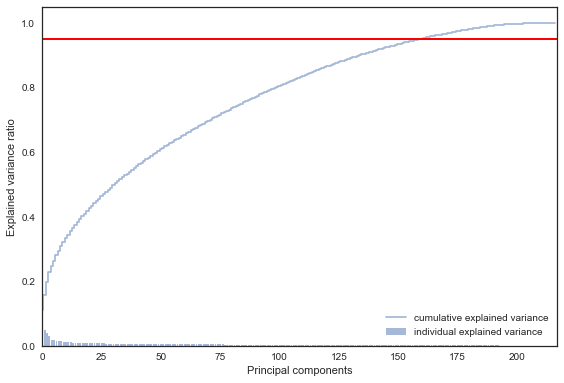

In [12]:
plt.bar(range(sklearn_pca.n_components_), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(sklearn_pca.n_components_), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
plt.axhline(y=0.95, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim([0, sklearn_pca.n_components_])
plt.legend(loc='best')
plt.tight_layout()

keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print "Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_

## Retaining only some vectors <a id="final-pca" />

You should decide now how many components you want to keep and change the following parameter.

By default we keep the recommended value from the above figure

In [13]:
retained_components_number = keep_recommend

Let's run the PCA again but with a limited number of components this time

In [14]:
sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

## Visualizing the eigenvectors in the original feature space <a id="original-space" />

### Decomposition heatmap

Each of our eigenvectors has a linear decomposition in the original feature space.

To understand which features were the most important, we can see how our eigenvectors are made of each original feature.

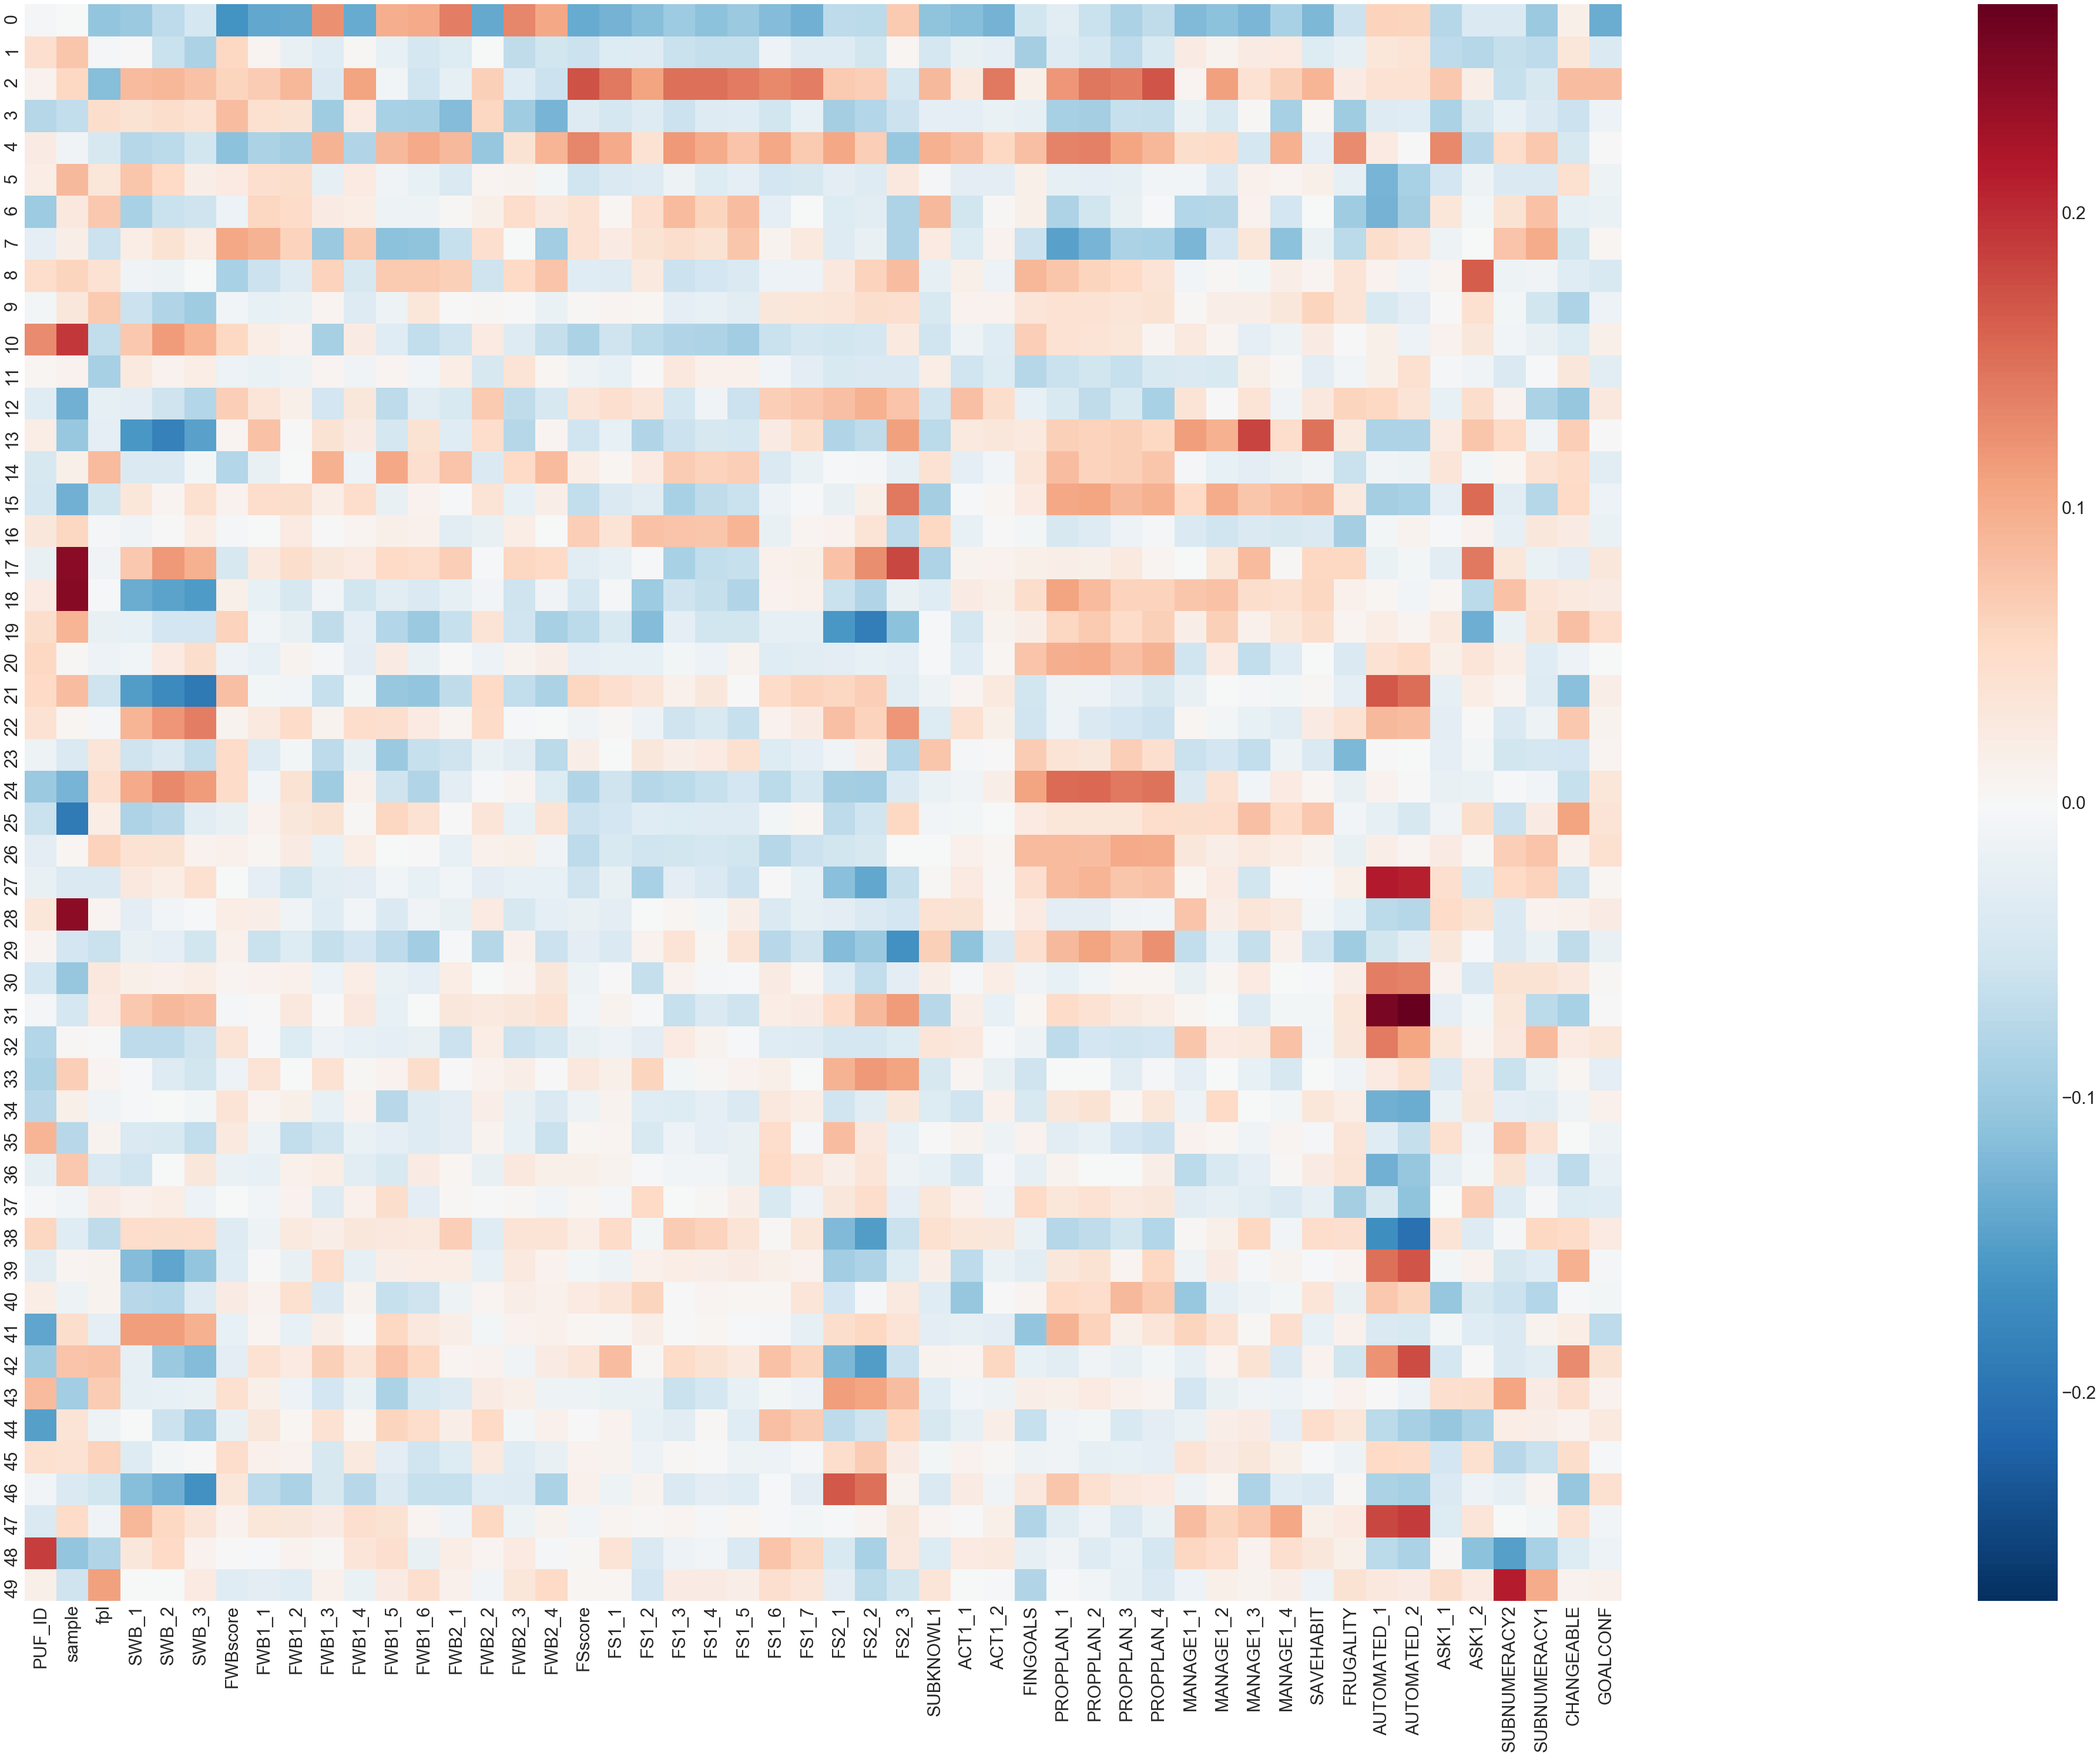

In [15]:
# For display reasons, we don't show all components if more than 50 (same for input variables)
n_components_to_show = min(50, sklearn_pca_final.n_components_)
n_input_features = sklearn_pca_final.components_.shape[1]

decomp_df = pd.DataFrame(sklearn_pca_final.components_[0:n_components_to_show],
                            columns=df.columns)
if decomp_df.shape[1] > 50:
    decomp_df = decomp_df[decomp_df.columns[0:50]]

fig = plt.figure(figsize=(n_input_features, n_components_to_show))
sns.set(font_scale=3)
sns.heatmap(decomp_df, square=True)
sns.set(font_scale=1)

### Visualizing projected vectors

The final visualization that we can build is the visualization of both the original dataset and the transformed dataset,
in the original feature space.

We are going to select two features of the original dataset, and show on a XY graph:

* A scatterplot of the original dataset
* A scatterplot of the reduced dataset (after losing the unexplained varaince)
* The projection of the first two eigenvectors on the two selected features.

In [16]:
if len(numerical_columns) >= 2:
    feat1 = numerical_columns[0]
    feat2 = numerical_columns[1]
else:
    raise ValueError("Failed to automatically select proper variables to plot, please select manually")
    
print "Will plot on these two features: '%s' and '%s'" % (feat1, feat2)

Will plot on these two features: 'PUF_ID' and 'sample'


In [17]:
# Uncomment this to take control on the two variables
# feat1 = "my_feat1"
# feat2 = "my_feat2"

In [18]:
idx_feat_1 = list(df.columns).index(feat1)
idx_feat_2 = list(df.columns).index(feat2)

(-2.0775735416327068,
 1.9658769636922004,
 -0.66613796777823542,
 3.1925465838371831)

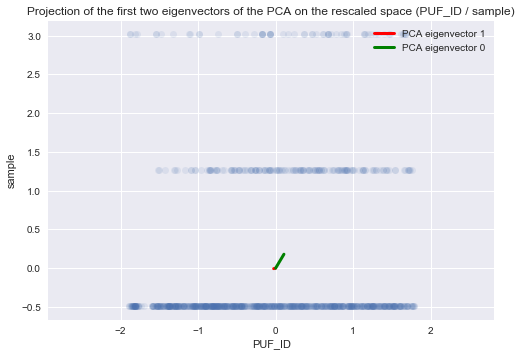

In [19]:
samp=1000
X_std_samp = np.random.choice(X_std.shape[0], samp)
plt.plot(X_std[X_std_samp, idx_feat_1], X_std[X_std_samp , idx_feat_2], 'o', alpha=0.1)
colors = ["green", "red"]
i = 0
for length, vector in zip(sklearn_pca_final.explained_variance_ratio_, sklearn_pca_final.components_)[0:2]:
    i = i+1
    i = i % len(colors)
    v = vector * 50 * length
    plt.plot([0, v[idx_feat_1]], [0, v[idx_feat_2]], '-k', lw=3, color=colors[i], label='PCA eigenvector ' + str(i))
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title('Projection of the first two eigenvectors of the PCA on the rescaled space (' + feat1 + ' / ' + feat2 + ')')
plt.legend(loc='upper right')
plt.axis("equal")

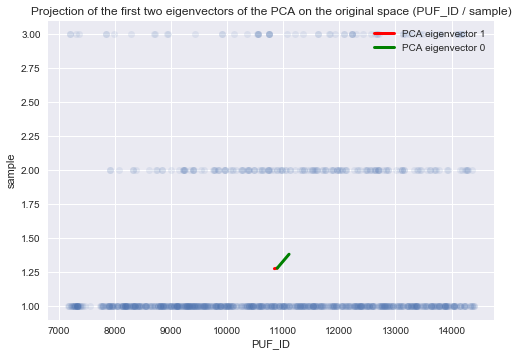

In [20]:
plt.plot(X[X_std_samp, idx_feat_1], X[X_std_samp , idx_feat_2], 'o', alpha=0.1)
colors = ["green", "red"]
i = 0
for length, vector in zip(sklearn_pca_final.explained_variance_ratio_, sklearn_pca_final.components_)[0:2]:
    i = i+1
    i = i % len(colors)
    #print vector
    v = ss.inverse_transform(vector * length * 50)
    #print v
    plt.plot([ss.mean_[idx_feat_1], v[idx_feat_1]], [ss.mean_[idx_feat_2], v[idx_feat_2]], '-k', lw=3, color=colors[i], label='PCA eigenvector ' + str(i))
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title('Projection of the first two eigenvectors of the PCA on the original space (' + feat1 + ' / ' + feat2 + ')')
plt.legend(loc='upper right')

(-2.2926265230246923,
 2.0669936195413996,
 -1.2267146860048006,
 3.7901337373758297)

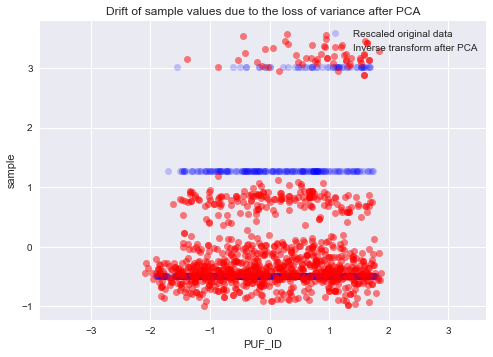

In [21]:
samp=1000
X_std_samp = np.random.choice(X_std.shape[0], samp)
X_new = sklearn_pca_final.inverse_transform(Y_sklearn_final)
plt.plot(X_std[X_std_samp, idx_feat_1], X_std[X_std_samp, idx_feat_2], 'o', alpha=0.2, color="blue", label="Rescaled original data")
plt.plot(X_new[X_std_samp, idx_feat_1], X_new[X_std_samp, idx_feat_2], 'ob', alpha=0.5, color="red", label="Inverse transform after PCA")
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.title('Drift of sample values due to the loss of variance after PCA')
plt.legend(loc='upper right')
plt.axis("equal")

## Applying the projection <a id="apply" />

Finally, we probably want to actually apply the PCA on the original data, which gives us the projected dataset

In [22]:
df_PCA = pd.DataFrame(Y_sklearn_final, columns=[("PCA_component_" + str(comp)) for comp in range(sklearn_pca_final.n_components)])

# Inserts back the date columns in the dataFrame with PCA applied
for date_col_idx in range(len(date_columns)):
    col = date_columns[date_col_idx]
    df_PCA.insert(date_col_idx , col, df_orig[col])

In [23]:
# Uncomment to display the head of the transformed matrix
df_PCA.head()

,PCA_component_0,PCA_component_1,PCA_component_2,PCA_component_3,PCA_component_4,PCA_component_5,PCA_component_6,PCA_component_7,PCA_component_8,PCA_component_9,PCA_component_10,PCA_component_11,PCA_component_12,PCA_component_13,PCA_component_14,PCA_component_15,PCA_component_16,PCA_component_17,PCA_component_18,PCA_component_19,PCA_component_20,PCA_component_21,PCA_component_22,PCA_component_23,PCA_component_24,PCA_component_25,PCA_component_26,PCA_component_27,PCA_component_28,PCA_component_29,PCA_component_30,PCA_component_31,PCA_component_32,PCA_component_33,PCA_component_34,PCA_component_35,PCA_component_36,PCA_component_37,PCA_component_38,PCA_component_39,PCA_component_40,PCA_component_41,PCA_component_42,PCA_component_43,PCA_component_44,PCA_component_45,PCA_component_46,PCA_component_47,PCA_component_48,PCA_component_49,PCA_component_50,PCA_component_51,PCA_component_52,PCA_component_53,PCA_component_54,PCA_component_55,PCA_component_56,PCA_component_57,PCA_component_58,PCA_component_59,PCA_component_60,PCA_component_61,PCA_component_62,PCA_component_63,PCA_component_64,PCA_component_65,PCA_component_66,PCA_component_67,PCA_component_68,PCA_component_69,PCA_component_70,PCA_component_71,PCA_component_72,PCA_component_73,PCA_component_74,PCA_component_75,PCA_component_76,PCA_component_77,PCA_component_78,PCA_component_79,PCA_component_80,PCA_component_81,PCA_component_82,PCA_component_83,PCA_component_84,PCA_component_85,PCA_component_86,PCA_component_87,PCA_component_88,PCA_component_89,PCA_component_90,PCA_component_91,PCA_component_92,PCA_component_93,PCA_component_94,PCA_component_95,PCA_component_96,PCA_component_97,PCA_component_98,PCA_component_99,PCA_component_100,PCA_component_101,PCA_component_102,PCA_component_103,PCA_component_104,PCA_component_105,PCA_component_106,PCA_component_107,PCA_component_108,PCA_component_109,PCA_component_110,PCA_component_111,PCA_component_112,PCA_component_113,PCA_component_114,PCA_component_115,PCA_component_116,PCA_component_117,PCA_component_118,PCA_component_119,PCA_component_120,PCA_component_121,PCA_component_122,PCA_component_123,PCA_component_124,PCA_component_125,PCA_component_126,PCA_component_127,PCA_component_128,PCA_component_129,PCA_component_130,PCA_component_131,PCA_component_132,PCA_component_133
0,-1.751849,2.922398,-2.388376,-4.407249,-0.659525,0.632953,3.082094,0.443986,2.750181,-0.972178,1.273894,1.681113,-0.944910,2.466888,1.242086,0.224552,0.040246,-0.581401,0.526126,-1.753026,-0.241271,-0.178162,1.517958,1.189868,1.312318,-0.107193,-0.021597,0.215673,0.119386,2.091738,-1.278873,-0.657063,-0.008792,1.488234,-0.022453,-0.883829,-1.889704,3.379290,-0.932840,0.274429,-0.323229,2.592071,-0.835910,0.005882,0.906370,0.935167,-0.838942,0.731745,-1.115537,0.921203,2.098762,-1.013598,0.713730,-0.977032,-0.761759,0.909300,3.011942,4.068996,-0.387169,-2.201964,5.351721,-1.886303,-0.187690,-0.803976,2.238054,0.347054,-0.286550,2.416063,0.003970,0.796974,-0.379070,-1.013361,-1.110857,-0.283850,-0.021581,0.941808,1.711184,-1.057230,-0.398364,-0.386948,-1.933918,1.393197,-0.678294,-0.467483,0.336479,1.851091,1.614263,-0.957559,-0.342552,1.284597,0.127797,0.697451,-0.169949,1.399971,0.457249,0.829653,-0.295036,-2.294743,0.847400,1.376765,-1.070120,0.974852,0.614080,-1.016597,-0.901011,0.127364,0.460470,0.592164,0.036864,-0.160890,-0.521673,0.824489,0.672935,0.745457,0.141075,0.256670,-0.001902,-0.294639,0.542356,-0.533252,0.167726,0.575453,-0.403633,-0.577844,-0.796106,-0.911107,0.328113,-0.576465,0.342692,0.697560,0.666373,0.555190,-0.230945,0.431073
1,2.771010,-0.482696,-2.864047,1.907340,-0.556257,-1.132921,-1.099071,-1.101418,-2.117178,-1.532689,-1.400458,-1.930314,-0.130936,-2.254249,0.042227,-1.009311,1.371859,0.372499,-2.325980,0.537690,0.050031,-0.810264,-0.886327,1.006949,-0.745141,-1.267202,0.353277,-0.077355,0.425599,-0.638067,-0.259334,-1.457310,0.734943,1.248459,0.297759,0.824478,-0.083963,-0.190124,0.806120,0.089523,-1.270565,0.944092,0.308537,0.351530,0.96

In [29]:
df_PCA.shape[1]

134